# Longitudinal Connectomes Analysis

Supporting code for
> Óscar Peña-Nogales, Timothy M. Ellmore, Rodrigo de Luis-García, Jessika Suescun, Mya C. Schiess and Luca Giancardo. Longitudinal Connectomes as a Candidate Progression Marker for Prodromal Parkinson's Disease. Frontiers in Neuroscience 12, 1–13 (2019).
https://doi.org/10.3389/fnins.2018.00967


__Background and Goal__

Parkinson's disease is the second most prevalent neurodegenerative disorder in the Western world. It is estimated that the neuronal loss related to Parkinson’s disease precedes the clinical diagnosis by more than 10 years (prodromal phase) which leads to a subtle decline that translates into non-specific clinical signs and symptoms. By leveraging diffusion magnetic resonance imaging brain (MRI) data evaluated longitudinally, at least at two different time points, we have the opportunity of detecting and measuring brain changes early on in the neurodegenerative process, thereby allowing early detection and monitoring that can enable development and testing of disease modifying therapies.

__Data Analysis (Task and Dataset)__

In this work, we aim to identify and quantify a longitudinal degenerative Parkinson's disease pattern from the diffusion magnetic resonance imaging connectivity information that can be found in a de novo early Parkinson's disease cohort (n=21) and in a cohort at high risk of being in the Parkinson's disease prodromal phase (n=16) that was not present in cohort matched Controls (n=30). This progression pattern was numerically quantified with a longitudinal brain connectome progression score. This score is generated by an interpretable machine learning algorithm trained, with cross-validation, on the longitudinal connectivity information of Parkinson's disease and Control groups computed on a nigrostriatal pathway-specific parcellation atlas. 

Data used in the preparation of this article were obtained from the Parkinson’s Progression Markers Initiative (PPMI) database (www.ppmi-info.org/data); for up to date information on the study, visit www.ppmi-info.org.

__Results__

Experiments indicated that the longitudinal brain connectome progression score was able to discriminate between the progression of Parkinson’s disease and Control groups with an area under the receiver operating curve of 0.89 [confidence interval (CI): 0.81–0.96] and discriminate the progression of the High Risk Prodromal and Control groups with an area under the curve of 0.76 [CI: 0.66–0.92].

__Conclusions__

Results suggest that it is possible to quantify neurodegenerative patterns of progression in the prodromal phase with longitudinal diffusion magnetic resonance imaging connectivity data and use these image-based patterns as progression markers for neurodegeneration.

# Analysis Pipeline

![analysis pipeline](imgs/long-connectomes-graph.jpg "analysis pipeline")

Pipeline for the proposed experimental approach. On the left, an overview of the structural connectome generation is shown. The PD25 subcortical atlas was nonlinearly registered with the T1 skull-stripped volumes. T1 brain extractions were visually inspected. If large parts of the brain were missing, a dilated T2 skull-stripped mask was used to compute the T1 brain extraction. Next, the T1 volume was registered to the b0 dMRI volume space using a standard nonlinear registration. Then, the atlas was transformed onto the b0 dMRI space to parcellate the diffusion volumes into 16 subcortical areas, and a probabilistic whole brain streamline tractography and its associated structural connectome were created. Averaged fractional anisotropy and averaged mean diffusivity connectomes were also computed. On the right, the various steps to create the longitudinal connectomes and output the Parkinson’s disease-relevant progression metric are shown. An L1-Norm distance metric was used to build the longitudinal connectomes between baseline and year-1 follow-up for the structural, fractional anisotropy, and mean diffusivity connectomes. Finally, the three longitudinal connectomes of each Parkinson’s disease (PD) and Control participant were concatenated into a single feature vector and used to train an L1-norm regularized logistic regression classifier. Further, the obtained progression metric from the trained datasets was generalizable to discriminate PROD from Controls.

# Import Libraries

In [9]:
#imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle as pk
import gzip
import sys

import utils
import utilsStats
import statsmodels.api as sm

import copy
import sklearn.metrics as met

# set Seaborn appearance
import seaborn as sns
sns.set_context("notebook", font_scale=1.5  ) 
sns.set_style("whitegrid")


import mlconn.conn_utils as conn_utils
import mlconn.temporal_conn as t_conn


# Load configuration
CONF_FILE = 'data/configuration.json'
CONF = utils.readConf(CONF_FILE)

%matplotlib inline

In [10]:
# relaunch this cell if custom modules are edited
reload(utils)
reload(conn_utils)
reload(t_conn)

<module 'mlconn.temporal_conn' from 'mlconn/temporal_conn.pyc'>

# Generate Dataset

Load all imaging and clinical data to be analyzed

In [11]:
# node names
connFr = conn_utils.getFSnodes(CONF['PD25_NODES'])

# GT
if os.path.exists( CONF['SUBJ_MATCHED_INFO'] ):
    imgInfoFr2 = pd.read_csv( CONF['SUBJ_MATCHED_INFO'], index_col='Subject' )
    # convert columns to datetime
    imgInfoFr2.adate = imgInfoFr2.adate.astype('datetime64')
    imgInfoFr2.adate_lst  = imgInfoFr2.adate_lst.astype('datetime64')
    
else:
    # load and match candidates
    imgInfoFr = t_conn.getImgInfoFL(CONF['SUBJ_FULL_INFO'])
    imgInfoFr2 = imgInfoFr.copy()

    # keep only subject with multiple visits (use "Visit" field to compute and remove people with visit 0)
    lblMulVis = (imgInfoFr2.daysDiff > 0)
    imgInfoFr2 = imgInfoFr2[lblMulVis]
    # remove images not analysable
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3859]
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3572]
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3811]
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3360]
    imgInfoFr2 = imgInfoFr2[imgInfoFr2.index.values != 3105]

    # store 
    imgInfoFr2.to_csv( CONF['SUBJ_MATCHED_INFO'], index=True )
    

# copy filtered 
imgInfoFr2full = imgInfoFr2.copy()

# Generate feature matrix and labels

Create the feature vectors representing the brain connectomes

In [12]:
#================================= Gen Feature Matrix
def genFeatMat( imgInfoFrIn, colNameIn='fsName' ):
    """
    Generate feature matrix and labels from imgInfoFr
    return (X->feature matrix ,y->labels)
    """

    # create feature vector/GT
    X = [] 
    y = []
    for i in range(len(imgInfoFrIn)):
        try:

            # all connectomes to be merged
            connDic = {'1': '2_connectomeLocal_ShiftTrim.csv','2': '2_FaconnectomeLocalFSL_ShiftTrim.csv','3': '2_AdcconnectomeLocalFSL_ShiftTrim.csv'}
            connVec=[]
            for conn in connDic:
                # connectome info 
                connArr = conn_utils.loadConnectome(imgInfoFrIn, i,connName=connDic[conn], baseDir=CONF['DIR_CONNECTOMES'], colName=colNameIn)
                conn_oneVec = conn_utils.compConnVec(connArr)

                # Merge all the features into the same vector
                connVec=np.concatenate((conn_oneVec,connVec), axis=0)
            
            X.append( connVec )

            y.append( imgInfoFrIn.iloc[i]['GT'] )
        except:
            print 'error:', imgInfoFrIn.iloc[i][colNameIn]
    # convert to numpy
    X = np.array(X)
    y = np.array(y)
    return (X,y)

def genFeatDeltaMat( imgInfoFrIn, colNameDelta=['fsName', 'fsName_lst'] ):
    """
    Compute the delta between the two feature vector colNameDelta(1)-colNameDelta(0)
    """
    X0, y = genFeatMat( imgInfoFrIn, colNameIn=colNameDelta[0] )
    X1, _ = genFeatMat( imgInfoFrIn, colNameIn=colNameDelta[1] )
    # delta
    X = np.abs(X1 - X0)

    
    return X,y, X0, X1

#=== set Ground Truth
imgInfoFr2['GT'] = -1
#select PD and CNT. If we want to select everything set all of the lables to 1.
imgInfoFr2.loc[imgInfoFr2.Group == 'PD', 'GT'] = 1
imgInfoFr2.loc[imgInfoFr2.Group == 'Control', 'GT'] = 0

# only two classes (PD/CNT)
imgInfoFr2 = imgInfoFr2[imgInfoFr2['GT']>=0]

# generate feature mat/labels (for PD/CNT)
(X,y, X0, X1) = genFeatDeltaMat( imgInfoFr2 )

#--generate feature mat/labels (for prodromal)
# set GT
imgInfoFr3 = imgInfoFr2full.copy()

imgInfoFr3['GT'] = -1
#select only Prodromal.
imgInfoFr3.loc[imgInfoFr3.Group == 'Prodromal', 'GT'] = 2
imgInfoFr3 = imgInfoFr3[imgInfoFr3['GT']==2]
# generate feature mat/labels for Prodromal (not used for cross-validation)
(Xout,yOut, Xout0, Xout1 ) = genFeatDeltaMat( imgInfoFr3 )
#--
#=================================



# Demographic comparison

In [13]:
# set groups
groupCntFr = imgInfoFr2full[imgInfoFr2full['Group'] == 'Control' ] 
groupProdrFr = imgInfoFr2full[imgInfoFr2full['Group'] == 'Prodromal' ] 
groupPdFr = imgInfoFr2full[imgInfoFr2full['Group'] == 'PD' ] 
# set comparison
groupsCmpLst = [ [groupCntFr,groupPdFr],[groupCntFr,groupProdrFr] ]
groupsLblLst = ['CNT vs. PD','CNT vs. Prodromal']
# run stats
for (group1Fr,group2Fr), lbl in zip(groupsCmpLst,groupsLblLst ):
    print '============== Compare ', lbl

    print 'Group 1: {:}, Group 2: {:}'.format(len(group1Fr),len(group2Fr))
    print 'Age {:}'.format( utilsStats.sigTestAUC( group1Fr.Age.values, group2Fr.Age.values ) )
    print 'Women  {:}'.format( utilsStats.sigTestAUC( (group1Fr.Sex == 'F').values, (group2Fr.Sex== 'F').values ) )
    print 'Days diff {:}, g1: m {:0.2f} std {:0.2f}; g2: m {:2f} std {:2f}' \
                                .format( utilsStats.sigTestAUC( group1Fr.daysDiff.values, group2Fr.daysDiff.values), 
                                            np.mean(group1Fr.daysDiff.values/365), np.std(group1Fr.daysDiff.values/365),
                                            np.mean(group2Fr.daysDiff.values/365), np.std(group2Fr.daysDiff.values/365) )


groupCntProdrFr = groupCntFr.append(groupProdrFr)

print 'Days diff glob: m {:0.2f} std {:0.2f}' \
                                .format(np.mean(groupCntProdrFr.daysDiff.values/365), np.std(groupCntProdrFr.daysDiff.values/365) )

        

============== Compare  CNT vs. PD
Group 1: 30, Group 2: 21
Age 0.61 (not sig. p=0.19)
Women  0.41 (not sig. p=0.18)
Days diff 0.54 (not sig. p=0.67), g1: m 1.10 std 0.24; g2: m 1.084801 std 0.116754
============== Compare  CNT vs. Prodromal
Group 1: 30, Group 2: 16
Age 0.58 (not sig. p=0.40)
Women  0.38 (not sig. p=0.09)
Days diff 0.49 (not sig. p=0.92), g1: m 1.10 std 0.24; g2: m 1.095719 std 0.271871
Days diff glob: m 1.10 std 0.25


No statistically significant differences were found between Control and PROD groups, and Control and Parkinson’s disease groups in age (P = 0.40, and P = 0.19, respectively) or gender (P = 0.09, and P = 0.18, respectively). However, the PROD group had a disproportionate number of men, as RBD occurs much more often in men vs. women

# Run Machine Learning Models

Run machine learning models on longitudinal connectomes and compare performance

In [14]:
# init ExpDic
expDic = {'name': 'Longitudinal connectome (l1 diff)', 'mdlDic': None, 'yCvArr': None, 'auc': None, 'gsDic': None}

param = {'NUM_RAND_WEIGHTS':65,'N_SPLITS': 21} # NUM_RAND_WEIGHTS=65 ->  equals to 65*21  random permutations


# Load or RUM ML models
if not os.path.exists( CONF['SAVED_CONN_FEATURES'] ):
    # ML model 
    expDic = t_conn.runMLord( X, y, Xout, param )        
    
    # save
    f = gzip.open(CONF['SAVED_CONN_FEATURES'], 'wb')
    pk.dump(expDic,f)
    f.close()
else:
    print 'loading old scores from ', CONF['SAVED_CONN_FEATURES']
    # load
    f = gzip.open(CONF['SAVED_CONN_FEATURES'],'rb')
    expDic = pk.load(f)
    f.close()

    
    
# print cross-validation performance PD/CNT for all classifiers
print '='*60,'CNT vs. PD (leave-subject-out-validation)'
t_conn.printMLperf( expDic, y, stdInfo=True, latexInfo=False )
print '='*60

# print performance CNT/PROD for all classifiers
print '='*60,'CNT vs. PROD (PROG group not used for training)'
t_conn.printMLperfOutScores( expDic, y, stdInfo=True, latexInfo=False ) 
print '='*60
print 'The statistical significances above are computed with Mann–Whitney U test not corrected for age and gender.'

loading old scores from  data/scores-models-weights.pklz
============================================================ CNT vs. PD (leave-subject-out-validation)
-------------------- Logistic Regression (L1 reg.)
0.89 (***p<0.001)
roc_auc_t: 0.889, sens: 0.905, spec: 0.767, acc: 0.824, kappa: 0.648, bal. acc: 0.836, cutoffTh: 0.329
-------------------- Logistic Regression (L2 reg.)
0.61 (not sig. p=0.19)
roc_auc_t: 0.610, sens: 0.667, spec: 0.600, acc: 0.627, kappa: 0.257, bal. acc: 0.633, cutoffTh: 0.334
-------------------- Elastic Net
0.69 (*p<0.05)
roc_auc_t: 0.689, sens: 0.762, spec: 0.600, acc: 0.667, kappa: 0.345, bal. acc: 0.681, cutoffTh: 0.382
-------------------- Linear SVM
0.52 (not sig. p=0.86)
roc_auc_t: 0.516, sens: 0.476, spec: 0.633, acc: 0.569, kappa: 0.110, bal. acc: 0.555, cutoffTh: 0.418
-------------------- Random Forest Classifier
0.76 (**p<0.01)
roc_auc_t: 0.757, sens: 0.762, spec: 0.733, acc: 0.745, kappa: 0.485, bal. acc: 0.748, cutoffTh: 0.400
=================

Performance comparison of machine learning (ML) models to distinguish between CNT and PD progression  (upperer experiments). Performance comparison of the generalization ability to distinguish between CNT and PROD progression without retraining the models (lower experiments). 

Logistic regression with L1 regularization and random forest are the only ML models able to distinguish between CNT and PD progression. In addition, they are the only ones able to identify Parkinson’s disease like progression on the PROD cohort. All metrics from logistic regression with L1 regularization are higher than the metrics from random forest, which indicates the better performance of this ML model. 

# Plot ROC Curve Comparison
of the best working models on Prodromal and PD subjects

In [15]:
#=== Set main model id and test for all the plots/analyis that follows
mdlDic = expDic
modelID = 0 # Logistic Regression (L1 reg.)
yCvArr = y
#===

#================================= Create ML score dataFrame for main model ID

# convert to DataFrame
scoresArr = mdlDic[modelID]['scores']
scoresTmpFr = pd.DataFrame( {'scores': scoresArr, 'gt': yCvArr.astype(int) }  )

# add out of cross validation predictions
scoresOutArr = np.median( mdlDic[modelID]['scoresOut'] , 0)
scoresFullArr = np.append( scoresArr, scoresOutArr )
yFull = np.append( yCvArr, yOut  )

# create ordered dataframe to match the scores
# (this assumes the use of ordered scores t_conn.runMLord)
imgInfoOrdFr = imgInfoFr2.append(imgInfoFr3)

# convert to DataFrame
# (this assumes the use of ordered scores t_conn.runMLord)
scoresFr = pd.DataFrame( {'scores': scoresFullArr, 'gt': yFull.astype(int), 'pID': imgInfoOrdFr.index.values, 'Group': imgInfoOrdFr.Group }  )

# short the elements
scoresFr.at[scoresFr['gt']==2,'gt']=-1
scoresFr.at[scoresFr['gt']==1,'gt']=2
scoresFr.at[scoresFr['gt']==-1,'gt']=1
#=================================

#================================= Add all other ML scores to the dataFrame
for i in expDic.keys():
    # load ML scores for given model
    scoresTmpArr = mdlDic[i]['scores']
    scoresOutTmpArr = np.median( mdlDic[i]['scoresOut'] , 0)
    # add column to scoresFr
    scoresFr['scores-'+str(mdlDic[i]['name'])] = np.append( scoresTmpArr, scoresOutTmpArr )

#=================================

Text(0.5,1,'Longitudinal Brain Connectomes Discrimination')

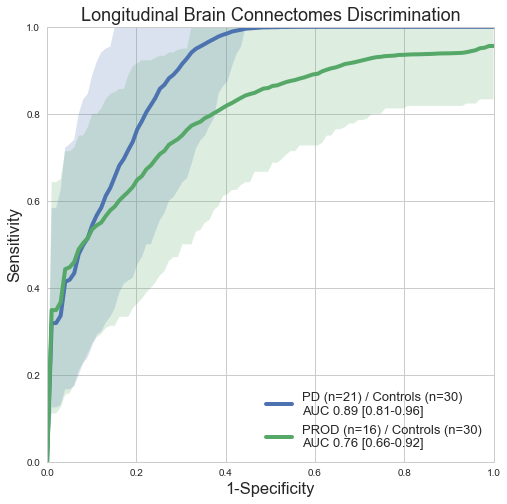

In [16]:
def rocInfo( scoresIn, yIn, lblIn, toInvert=False, printSig=False ):
    rocDic = {}
    pdArr = scoresIn[ yIn==1 ]
    cntArr = scoresIn[ yIn==0 ]
    (rocDic['aucConfDown'], rocDic['aucConfUp'], 
     rocDic['fprGridVec'], rocDic['tprGridMat'] ) = conn_utils.rocBootstrap( cntArr, pdArr)
    rocDic['leg'] = '{:}\nAUC {:} [{:0.2f}-{:0.2}]'.format( lblIn,
                                                            utilsStats.sigTestAUC( cntArr, pdArr, 'auc' ), 
                                                            rocDic['aucConfDown'], rocDic['aucConfUp'] )
    

    if printSig:
        print  utilsStats.sigTestAUC( cntArr, pdArr, 'long' )
    return rocDic

def formatROC():
    plt.legend( loc='lower right', prop={'size':13} ) 
    #aucTitleLbl = '\nAUC {:} [{:0.2f}-{:0.2}]' .format( utilsStats.sigTestAUC( cntFullScoresFr.nqScore.values ,pdFullScoresFr.nqScore.values ), aucConfDown, aucConfUp )
    plt.xlabel('1-Specificity' )
    plt.ylabel('Sensitivity')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.tick_params(axis="y", labelsize=10 )
    plt.tick_params(axis="x", labelsize=10 )

# plot roc
plt.figure( figsize=(8,8) ) 
lblsLst = (scoresFr['Group'] == 'PD') | (scoresFr['Group'] == 'Control')
roc0 = rocInfo( scoresFr[lblsLst]['scores'], scoresFr[lblsLst]['gt']>1, 'PD (n=21) / Controls (n=30)' )
conn_utils.plotRocAndConf( roc0['fprGridVec'], roc0['tprGridMat'], roc0['leg']  )

lblsLst = (scoresFr['Group'] == 'Prodromal') | (scoresFr['Group'] == 'Control')
roc1 = rocInfo( scoresFr[lblsLst]['scores'], scoresFr[lblsLst]['gt']==1, 'PROD (n=16) / Controls (n=30)' )
conn_utils.plotRocAndConf( roc1['fprGridVec'], roc1['tprGridMat'], roc1['leg'] )



formatROC()
plt.title('Longitudinal Brain Connectomes Discrimination')    
    

Receiver operating characteristic (ROC) curves showing the discriminative performance of the longitudinal brain connectomes in distinguishing Parkinson’s disease (PD) from Controls (blue line) and PROD from Controls (green line) with a model trained to recognize Parkinson’s disease-progression. Parkinson’s disease n = 21, PROD n = 16, Control n = 30, all longitudinal connectomes were computed using 1 year progression from the baseline visit. The shaded areas represent the confidence intervals of the ROC curves. AUC: Area under the ROC curve (perfect discrimination = 1.0, random discrimination = 0.5).

# Significant Connections
Compute the most signifincant longitudinal connections relevant to classify PD vs control progression

/Users/lgiancardo/miniconda2/envs/pd-long-env/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in divide


Text(0.5,1.05,'MD')

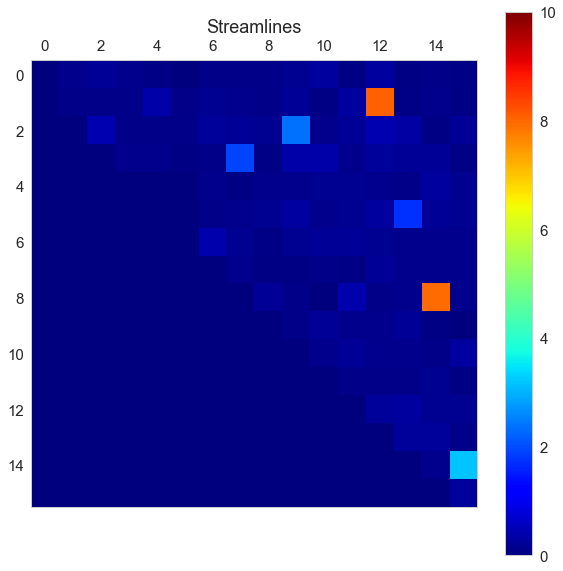

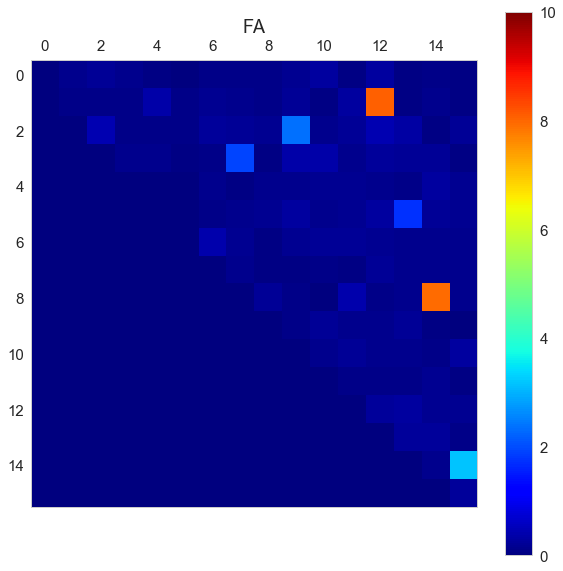

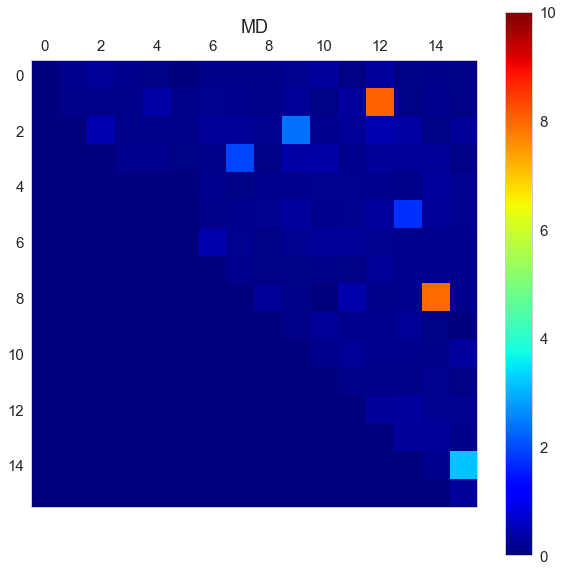

In [17]:
def genFullWeightMat( featWeightLst, op=np.average, conn='stream'  ):
    """
    Create matrix from list feat weight and run vector operation
    """
    # cnv to numpy
    featWeightArr  = np.array(featWeightLst)
    # run operation (np.average, np.std, etc. on absolute values)
    res = op(np.abs(featWeightArr), 0)
    # convert to matrix
    # first - split weights of the three connectomes:
    if conn is 'stream':
        res = res[:136] 
    elif conn is 'FA':
        res = res[136:-136]
    elif conn is 'MD':
        res = res[-136:]
    fullWeightMat = conn_utils.compVec2Conn(res)
    
    return fullWeightMat

def plotHeatMap(matIn, **matarg):
    plt.figure(figsize=(10,10))
    plt.matshow( matIn,fignum=False, **matarg )
    plt.set_cmap( 'jet' )
    plt.grid(False)
    plt.colorbar()




def computeStdDevMat( weightMat, rndWeightMat, connIn='stream' ):
    """
    Compute relevance matrix based on standard deviations from noise
    """
    # calculate full weight matrix
    # The number of weights is 21 * 408. Those 408 are devided by 136*3, for each connetome (structural, FA, MD). 
    fullWeightMat = genFullWeightMat(weightMat, np.average, connIn)
    # rnd weights distributions
    rndWeightAvgMat = genFullWeightMat(rndWeightMat, np.average, connIn)
    rndWeightStdMat = genFullWeightMat(rndWeightMat, np.std, connIn)

    # number of standard deviations from noise 
    fullWeightMatSN = np.abs(fullWeightMat - rndWeightAvgMat) / rndWeightStdMat
    # remove division by 0s
    fullWeightMatSN[~np.isfinite(fullWeightMatSN)] = 0
    
    return fullWeightMatSN


# calculate full weight matrix
# The number of weights is 21 * 408. Those 408 are devided by 136*3, for each connetome (structural, FA, MD). 
conn = 'stream'
weightSnStMat = computeStdDevMat( mdlDic[modelID]['featWeight'], mdlDic[modelID]['rndFeatWeights'], conn )
plotHeatMap(weightSnStMat, vmin=0, vmax=10 )
plt.title('Streamlines')
conn = 'FA'
weightSnFaMat = computeStdDevMat( mdlDic[modelID]['featWeight'], mdlDic[modelID]['rndFeatWeights'], conn )
plotHeatMap(weightSnStMat, vmin=0, vmax=10 )
plt.title('FA')
conn = 'MD'
weightSnMdMat = computeStdDevMat( mdlDic[modelID]['featWeight'], mdlDic[modelID]['rndFeatWeights'], conn )
plotHeatMap(weightSnStMat, vmin=0, vmax=10 )
plt.title('MD')



Matrices visually displaying  the most relevant longitudinal connections on three different definitions of connectivity.

The names of the areas are available in connFr.area or by running the code below


In [18]:

def printRelConn( weightSnIn, stdThIn ):
    # find relevant connections
    cLst, rLst = np.nonzero(weightSnIn>stdThIn)
    # weights and label generator
    weightsLst = []
    lblLst = []    
    for c,r in zip(cLst,rLst):
        lbl = connFr.area.iloc[c] + ' ' + connFr.area.iloc[r]
        lblLst.append(lbl)
        weightsLst.append(weightSnIn[c,r])
    # sort by weights
    sortedIds = np.argsort( -1 * np.array(weightsLst) )
    
    for sId in sortedIds:
        print lblLst[sId], '({:0.2f})'.format(weightsLst[sId])
        
# According to Chebyshev's inequality, 5 STD contains at least 96% of noise
stdTh = 5
print '='*40, '5 std as Threshold'

print '='*20, 'Streamlines'
printRelConn( weightSnStMat, stdTh ) 
print '='*20, 'FA'
printRelConn( weightSnFaMat, stdTh ) 
print '='*20, 'MD'
printRelConn( weightSnMdMat, stdTh ) 
print '='*40

stdTh = 1
print '\n\n', '='*40, '1 std as Threshold'

print '='*20, 'Streamlines'
printRelConn( weightSnStMat, stdTh ) 
print '='*20, 'FA'
printRelConn( weightSnFaMat, stdTh ) 
print '='*20, 'MD'
printRelConn( weightSnMdMat, stdTh ) 
print '='*40

======================================== 5 std as Threshold
==================== Streamlines
right-red-nucleus left-globus-pallidus-interna (8.08)
left-putamen left-thalamus (7.97)
==================== FA
left-globus-pallidus-externa right-globus-pallidus-externa (6.67)
left-putamen left-globus-pallidus-externa (6.66)
right-caudate right-thalamus (5.34)
==================== MD


======================================== 1 std as Threshold
==================== Streamlines
right-red-nucleus left-globus-pallidus-interna (8.08)
left-putamen left-thalamus (7.97)
left-thalamus right-thalamus (3.19)
left-substantia-nigra right-putamen (2.37)
right-substantia-nigra right-caudate (1.93)
right-subthalamic-nucleus right-globus-pallidus-interna (1.75)
==================== FA
left-globus-pallidus-externa right-globus-pallidus-externa (6.67)
left-putamen left-globus-pallidus-externa (6.66)
right-caudate right-thalamus (5.34)
left-putamen right-putamen (2.82)
right-red-nucleus left-putamen (1.90)
righ

Our machine learning (ML) model learns a combination of longitudinal connection changes from the Parkinson's disease (PD) and Control group. It combines three types of structural connectivity metrics. The most prominent connections used by our model are computed by using the number of standard deviations from the null distribution estimated with a random permutation test. Above, we show all connections above five standard deviations. No connections measured with mean diffusivity reached this level. Below, we show all connections above 1 standard deviation.

The analysis finishes here for simplicity. For additional tests go to https://github.com/lgiancaUTH/PD-Longitudinal-Connectome